In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from lib.Utility import exportExcelWithTimeStamp, calculateSize2, calculate_gain_full, calculateSize1, calculate_gain_quotaMin

from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# features = ['B365H','B365D', 'B365A',	'B365<2.5']
features = [
    # 'HomeGoalsCumulative', 'AwayGoalsCumulative'
    # , 'HomePointsCumulative','AwayPointsCumulative',
    #  'HomeGoalsConcededCumulative',	'AwayGoalsConcededCumulative',
             'PointsDifference'
            , 'ConcededGoalsDifference'
            , 'GoalsDifference'
            , 'AwayGoalsRatio'
            , 'HomeGoalsRatio'
            #  , 'B365D'
            #  , 'B365H'
            # , 'B365A'
            # , 'B365>2.5'
            ]
# features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'AwayPointsCumulative', 'HomeGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'AwayGoalsConcededCumulative']
# features = ['HomeGoalsCumulative', 'HomePointsCumulative']

threshold = 0.5

In [2]:
data = pd.read_excel('data/mergedDataFull.xlsx')
# data = pd.read_excel('data/engdata/24-25.xlsx')
# data = pd.read_excel('data/mergedDataSerieB.xlsx')
# data['Cluster'] = np.where(data['FTR'] == 'H', 1, np.where(data['FTR'] == 'A', 2, 0))
data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0) #data['FTR'].map({'D': 0, 'H': 1, 'A': 2}) 
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
data = data[data['B365D'].notna()]
data = data[data['B365H'].notna()]
data = data[data['B365A'].notna()]
# data = data[data['B365H']>1.6]
# data.dropna()
data.tail()

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayPointsCumulative,HomeGoalsConcededCumulative,AwayGoalsConcededCumulative,MatchGoal,PointsDifference,HomeGoalsRatio,AwayGoalsRatio,GoalsDifference,ConcededGoalsDifference,Cluster
8303,2024-04-27,E2,12:30:00,Reading,Blackpool,3,2,H,1.0,1.0,...,73,68,45,5,17,0.955882,1.400000,2,23,0
8304,2024-04-27,E2,12:30:00,Shrewsbury,Leyton Orient,1,3,A,0.0,2.0,...,62,64,54,4,14,0.531250,0.925926,16,10,0
8305,2024-04-27,E2,12:30:00,Stevenage,Cheltenham,2,1,H,1.0,0.0,...,44,45,63,3,24,1.222222,0.634921,15,18,0
8306,2024-04-27,E2,12:30:00,Wigan,Bristol Rvs,2,0,H,1.0,0.0,...,57,56,66,2,10,1.089286,0.787879,9,10,0
8307,2024-04-27,E2,12:30:00,Wycombe,Charlton,1,0,H,1.0,0.0,...,53,55,64,1,9,1.072727,1.000000,5,9,0


In [3]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()

print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (5800, 5) 
X_test: (2487, 5) 
y_train: (5800,) 
y_test: (2487,)


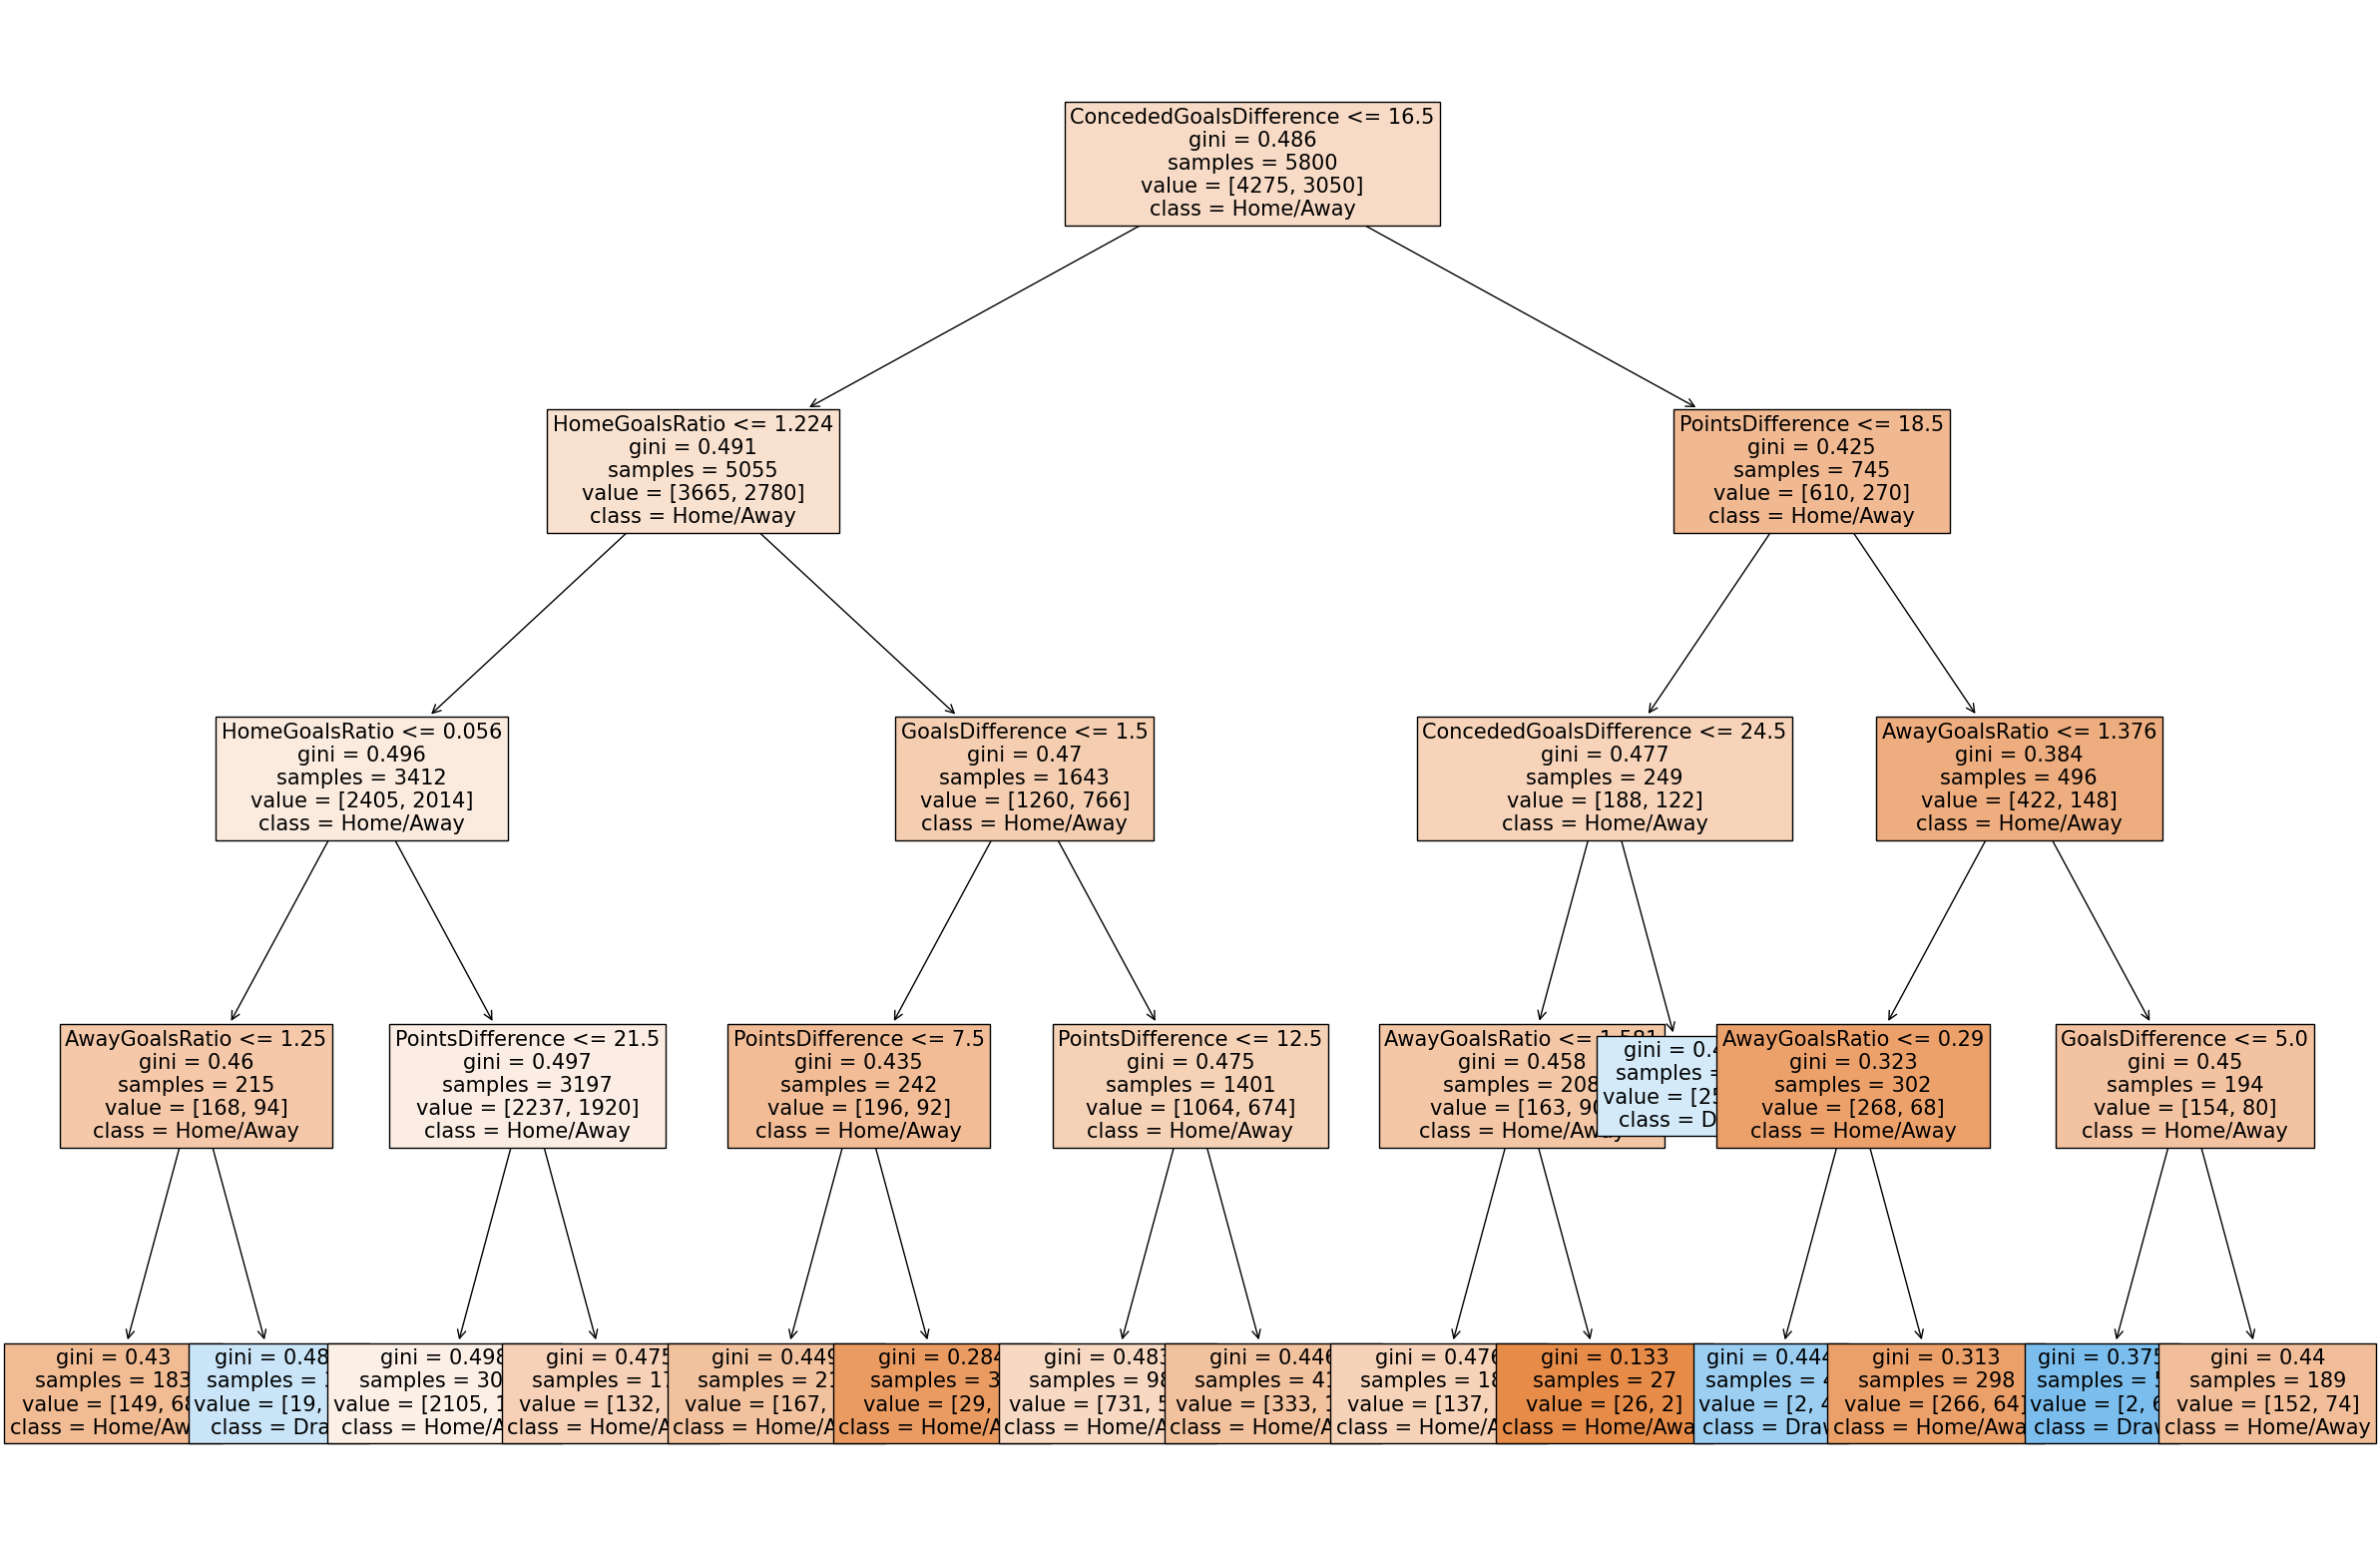

In [4]:

# Set regularization rate
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
reg = 0.01

# train a logistic regression model on the training set
model1 = LogisticRegression(C=1/reg, multi_class='ovr',
                            solver="liblinear", random_state=42).fit(x_train, y_train)

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=42).fit(x_train, y_train)
model2 = DecisionTreeClassifier(random_state=42, min_samples_split=50, class_weight={1: 2, 0: 1}, max_depth=4  # , ccp_alpha= 0.00001
                                , max_features=2
                                ).fit(x_train, y_train)
plt.figure(figsize=(30, 20))
tree.plot_tree(model2, feature_names=features, filled=True, fontsize=15               # ,proportion=True  # Mostra la proporzione delle classi
               , class_names=['Home/Away', 'Draw'])
plt.show()
# joblib.dump(model, "./Soccer-ml1.joblib")

# model = joblib.load("Soccer-ml3.joblib")

In [5]:
# from sklearn.tree import export_graphviz
# import graphviz

# # Supponiamo che il modello sia già addestrato
# # Supponiamo di avere feature_names e class_names definite

# dot_data = export_graphviz(model, out_file=None, feature_names=features, proportion=True  # Mostra la proporzione delle classi
#                            , class_names=['Home/Away', 'Draw'], filled=True,
#                            rounded=True,
#                            special_characters=True)

# # Creare un oggetto graphviz Source
# graph = graphviz.Source(dot_data)

# # Visualizzare il grafico
# # graph.view()

# # Per salvare il grafico in un file PDF, PNG, ecc.
# # Questo salverà il grafico come "decision_tree.pdf"
# graph.render("decision_tree")

In [6]:
def custom_predict(X, threshold, model):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)
# Definisci una funzione che applica la logica descritta
def calculate_gain(row, quota_minima):
    
    if(row['predictions'] > threshold):
        if row['Cluster'] == row['predictions']:
            if row['predictions'] == 1 and row['B365H'] > quota_minima:
                return row['B365H']-1
            elif row['predictions'] == 2 and row['B365A'] > quota_minima:
                return row['B365A']-1
            elif row['predictions'] == 0 and row['B365D'] > quota_minima:
                return row['B365D']-1
        else:
            if((row['predictions'] == 0 and row['B365D'] > quota_minima) or (row['predictions'] == 2 and row['B365A'] > quota_minima) or (row['predictions'] == 1 and row['B365H'] > quota_minima)):
                return -1
            


In [7]:
# x_test = data[features]
# y_test = data['Cluster']

df = x_test.copy()
# df['predictions'] = model.predict(x_test.sort_index())
df['predictionsLog'] = custom_predict(x_test.sort_index(), threshold, model1)
df['predictionsDT'] = custom_predict(x_test.sort_index(), threshold, model2)
pred_prob1 = model1.predict_proba(x_test.sort_index())
pred_prob2 = model2.predict_proba(x_test.sort_index())

df2 = pd.DataFrame(pred_prob1)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)



finalDataset = data[data.index.isin(x_test.index)]
finalDataset['predictionsLog'] = df['predictionsLog']
finalDataset['pred_probLog'] = df[1]

df2 = pd.DataFrame(pred_prob2)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset['predictionsDT'] = df['predictionsDT']
finalDataset['pred_probDT'] = df['1_y']

finalDataset['size1'] = calculateSize1(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['size2'] = calculateSize2(finalDataset['B365H'], finalDataset['B365A'])
finalDataset['gainLog1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probLog'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probLog'] > threshold), -1, None))
finalDataset['gainLog2'] = finalDataset.apply(calculate_gain_full, axis=1, args=('Log',))
finalDataset['gainDT1'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['pred_probDT'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['pred_probDT'] > threshold), -1, None))
finalDataset['gainDT2'] = finalDataset.apply(calculate_gain_full, axis=1, args=('DT',))

equityLog = finalDataset['gainLog1'].sum()
print("EquityLog", equityLog)
equityLog2 = finalDataset['gainLog2'].sum()
print("EquityLog2", equityLog2)

equityDT = finalDataset['gainDT1'].sum()
print("EquityDT", equityDT)

equityDT2 = finalDataset['gainDT2'].sum()
print("EquityDT2", equityDT2)

print(f"AccuracyLog score: {round(100*accuracy_score(y_test, df['predictionsLog']),2)}%")
print(f"AccuracyDT score: {round(100*accuracy_score(y_test, df['predictionsDT']),2)}%")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

C:\Users\vitto\AppData\Local\Temp\ipykernel_24344\1388480918.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDataset['predictionsLog'] = df['predictionsLog']
C:\Users\vitto\AppData\Local\Temp\ipykernel_24344\1388480918.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDataset['pred_probLog'] = df[1]
C:\Users\vitto\AppData\Local\Temp\ipykernel_24344\1388480918.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

EquityLog 0
EquityLog2 -296.4154537439909
EquityDT 6.750000000000002
EquityDT2 -283.3447594311563
AccuracyLog score: 73.66%
AccuracyDT score: 72.98%


In [8]:
# joblib.dump(model, "./Soccer-ml7L1.joblib")